In [12]:
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDPMPipeline, DDIMScheduler, UNet2DModel, DDPMScheduler
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"
device

c:\Users\Triton Neo 16\diffusion-teset\venv\lib\site-packages\diffusers\utils\outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


'cuda'

torch.Size([8, 1, 28, 28]) torch.Size([8])
labels: tensor([0, 4, 4, 5, 4, 2, 7, 6])


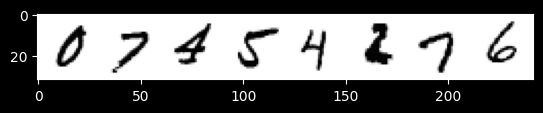

In [4]:
dataset = torchvision.datasets.MNIST(root='mnist/', train=True, download=True, transform=transforms.ToTensor())
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
x, y = next(iter(train_dataloader))
print(x.shape, y.shape)
print("labels:", y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

In [16]:
class ClassConditionedUnet(nn.Module):
    def __init__(self, num_classes: int=10, class_emb_size: int=4) -> None:
        super().__init__()
        self.class_emb = nn.Embedding(num_classes, class_emb_size)
        self.model = UNet2DModel(
            sample_size=28,
            in_channels=1 + class_emb_size,
            out_channels=1,
            layers_per_block=2,
            block_out_channels=(32, 64, 64),
            down_block_types=(
                "DownBlock2D",
                "AttnDownBlock2D",
                "AttnDownBlock2D",
            ), 
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D",
                "UpBlock2D",
            ),
        )
    def forward(self, x: torch.Tensor, t: torch.Tensor, class_labels: torch.Tensor) -> torch.Tensor:
        bs, ch, w, h = x.shape
        # print(f"{x.shape=}")
        class_cond = self.class_emb(class_labels)
        # print(f"class cond before view: {class_cond.shape=}")
        class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
        # print(f"class cond after view: {class_cond.shape=}")
        net_input = torch.cat((x, class_cond), 1)
        # print(f"{net_input.shape=}")
        # print(f"{t.shape=}")
        return self.model(net_input, t).sample


In [ ]:
noise_schedule = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")
train_dataloader: DataLoader = DataLoader(dataset, batch_size=128, shuffle=True)
n_epochs = 10
net = ClassConditionedUnet().to(device)
loss_fn = nn.MSELoss()
# opt = torch.optim.Adam(net.parameters(), lr=1e-3)
losses = []

In [ ]:
# net = torch.compile(net)

RuntimeError: Windows not yet supported for torch.compile

In [34]:
opt = torch.optim.Adam(net.parameters(), lr=1e-3)
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):
        x, y = x.to(device), y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 1000, (x.shape[0],)).to(device)
        noisy_x = noise_schedule.add_noise(x, noise, timesteps)
        pred = net(noisy_x, timesteps, y)
        loss = loss_fn(pred, noise)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())
    avg_loss = sum(losses[-100:]) / 100
    print(f"Epoch {epoch}, avg of the last 100 loss values: {avg_loss:.05f}")
plt.plot(losses)

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 0, avg of the last 100 loss values: 0.02614


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, avg of the last 100 loss values: 0.02607


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, avg of the last 100 loss values: 0.02605


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

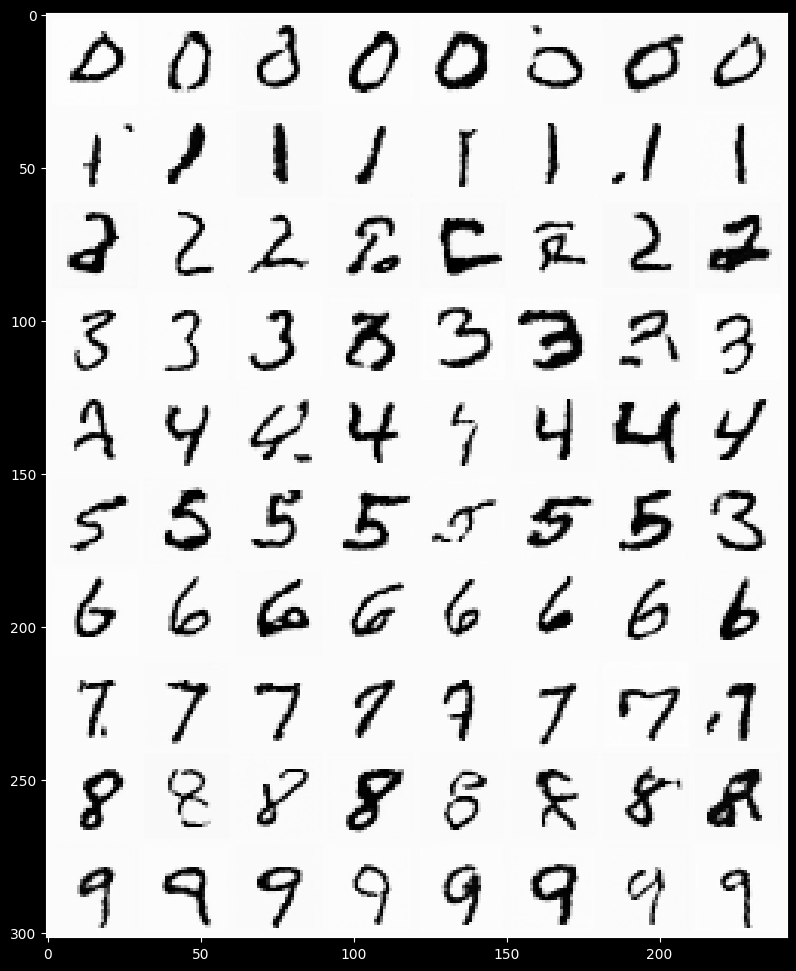

In [32]:
x = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)

for i, t in tqdm(enumerate(noise_schedule.timesteps), total=len(noise_schedule.timesteps)):
    with torch.no_grad():
        residual = net(x, t, y)
    x = noise_schedule.step(residual, t, x).prev_sample
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap='Greys')

In [30]:
# import required libraries
import torch

# create a tensor
t = torch.tensor([[1,2,3]])

# display the tensor
print("Tensor:", t)

# size of tensor is [1,3]
print("Size of Tensor:", t.size())
# t.expand(3,6) # open this line to see the error

Tensor: tensor([[1, 2, 3]])
Size of Tensor: torch.Size([1, 3])


RuntimeError: The expanded size of the tensor (6) must match the existing size (3) at non-singleton dimension 1.  Target sizes: [3, 6].  Tensor sizes: [1, 3]